## AutoKeras 설치

In [1]:
# !pip install autokeras

## 실습에 활용할 데이터셋 로드 (이미지)

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
mnist = tf.keras.datasets.mnist

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## 데이터셋 시각화

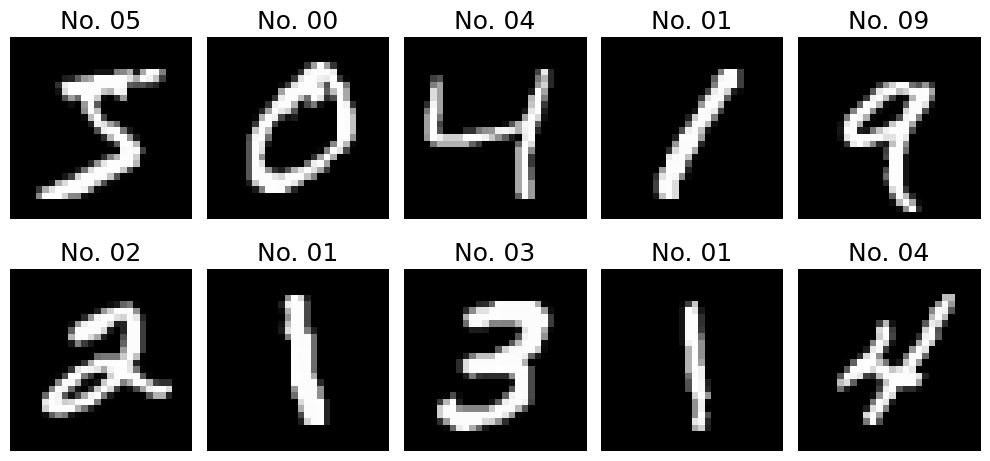

In [6]:
fig, axes = plt.subplots(2, 5)
fig.set_size_inches(10, 5)

for i in range(10):
    axes[i//5, i%5].imshow(x_train[i], cmap='gray')
    axes[i//5, i%5].set_title('No. %02d' % y_train[i], fontsize=18)
    plt.setp( axes[i//5, i%5].get_xticklabels(), visible=False)
    plt.setp( axes[i//5, i%5].get_yticklabels(), visible=False)
    axes[i//5, i%5].axis('off')

plt.tight_layout()
plt.show()

## AutoKeras 활용

In [7]:
import autokeras as ak

In [8]:
# 이미지 분류기 생성
model = ak.ImageClassifier(overwrite=True, max_trials=1)

In [9]:
# 모델 학습
model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=5, 
          validation_split=0.2)

Trial 1 Complete [00h 01m 22s]
val_loss: 0.03439665585756302

Best val_loss So Far: 0.03439665585756302
Total elapsed time: 00h 01m 22s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1602 - accuracy: 0.9504 - val_loss: 0.0680 - val_accuracy: 0.9775
Epoch 2/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0752 - accuracy: 0.9772 - val_loss: 0.0568 - val_accuracy: 0.9808
Epoch 3/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0606 - accuracy: 0.9814 - val_loss: 0.0438 - val_accuracy: 0.9850
Epoch 4/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0512 - accuracy: 0.9835 - val_loss: 0.0370 - val_accuracy: 0.9873
Epoch 5/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0459 - accuracy: 0.9855 - val_loss: 0.0385 - val_accuracy: 0.9872


INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


## 고급 모델

아래 코드를 실행하여 데이터셋을 다운로드 받습니다.

In [10]:
import urllib.request
import zipfile

# 데이터셋 다운로드
print('1) TRAIN 데이터셋 다운로드...')
url = 'https://www.dropbox.com/s/bpgvn248qtpavps/train.zip?dl=1'
urllib.request.urlretrieve(url, 'train.zip')
local_zip = 'train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('kfood/train')
zip_ref.close()

url = 'https://www.dropbox.com/s/v85arwr14aq3nj5/submission.csv?dl=1'
urllib.request.urlretrieve(url, 'kfood/submission.csv')
print('===' * 15)
print('[데이터셋 다운로드 완료]')

1) TRAIN 데이터셋 다운로드...
[데이터셋 다운로드 완료]


데이터 시각화

Found 3500 images belonging to 10 classes.
(32, 224, 224, 3) (32, 10)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


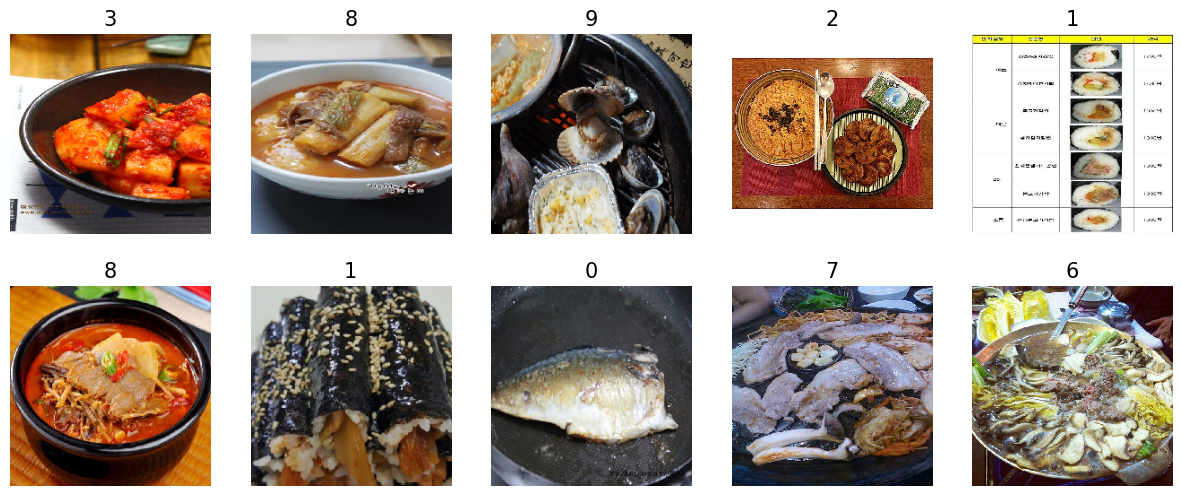

In [11]:
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경고 무시
warnings.filterwarnings('ignore')

# TRAIN, TEST 경로 지정
TRAIN_DIR = './kfood/train'

# 데이터 시각화 코드
original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory(TRAIN_DIR, 
                                                          target_size=(224, 224), 
                                                          batch_size=32
                                                         )

for x, y in original_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(f'{y[i].argmax()}', fontsize=15)
        axes[i//5, i%5].axis('off')
    break
plt.show()

## 디스크(disk) 공간에서 이미지 데이터 로드

In [12]:
batch_size = 32
img_height = 224
img_width = 224

train_data = ak.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(224, 224),
    batch_size=batch_size,
    # Use 20% data as testing data.
    validation_split=0.2,
    subset="training",
)

test_data = ak.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
)

Found 3500 files belonging to 10 classes.
Using 2800 files for training.
Found 3500 files belonging to 10 classes.
Using 700 files for validation.


## 고급 모델 생성

In [ ]:
# 입력 노드 정의
input_node = ak.ImageInput()

# 출력 노드 정의
output_node = ak.ImageBlock(
    # Only search ResNet architectures.
    block_type="resnet",
    # Normalize the dataset.
    normalize=True,
    # data augmentation.
    augment=False,
)(input_node)

output_node = ak.ClassificationHead()(output_node)

model = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=1
)

In [ ]:
model.fit(train_data,
          validation_data=(test_data),
          epochs=10)

In [ ]:
# Export as a Keras Model.
output_model = model.export_model()

print(type(output_model)) 

In [ ]:
output_model.save("image_model.h5")

## 모델 로드

학습이 완료된 샘플 모델을 다운로드 받습니다.

In [ ]:
!wget https://www.dropbox.com/s/rmsi5u3t21q9xzf/image_model.h5?dl=1 -O image_model.h5

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
loaded_model = load_model('image_model.h5')

## 이미지 URL로부터 예측

In [ ]:
from skimage import io

# 김밥 사진 URL
image_url = 'https://mp-seoul-image-production-s3.mangoplate.com/keyword_search/meta/pictures/oc1mqalnqarz3cwo.png'

# image 다운로드, 로드
image = io.imread(image_url)

# 시각화
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
def predict_image_from_url(url, model):
    food_list = {
        0: '고등어구이',
        1: '김밥',
        2: '김치볶음밥',
        3: '깍두기',
        4: '떡갈비',
        5: '미역국',
        6: '불고기',
        7: '삼겹살',
        8: '육개장',
        9: '조개구이',
    }
    # image 다운로드, 로드
    image = io.imread(url)

    # 시각화
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # 스케일, resize
    image = image / 255.0
    image = tf.image.resize(image, size=(224, 224))

    # 예측
    x = image.numpy()
    x = np.expand_dims(x, 0)
    pred = model.predict(x)
    result = pred.argmax(axis=1)
    print(f'예측 결과: {food_list[result[0]]}, 확률: {pred.max() * 100:.2f}%')

In [ ]:
predict_image_from_url('https://homecuisine.co.kr/files/attach/images/140/001/083/558d170258752df2dd76bef00861497f.JPG', loaded_model)

In [ ]:
predict_image_from_url('https://recipe1.ezmember.co.kr/cache/recipe/2015/12/24/7b10402a82606a5a3de6710c93a110f41.jpg', loaded_model)

In [ ]:
predict_image_from_url('http://m.dyfood.co.kr/web/product/big/20191123/e208b86b6237715e547e212a45597900.jpg', loaded_model)